In [182]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [183]:
# Utility Functions
def generate_colors(n):
    colors = []
    for i in range(n):
        ratio = i / max(n - 1, 1)

        r = max(0, min(1, abs(ratio * 6 - 3) - max(abs(ratio * 6 - 4) - 1, 0)))
        g = max(0, min(1, 1 - abs(ratio * 6 - 2)))
        b = max(0, min(1, 1 - abs(ratio * 6 - 4)))

        colors.append((r, g, b))
    return colors


In [184]:
def download_crypto_data(ticker="BTC-USD", period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)

    # Pilih kolom yang relevan dan drop missing
    data = data[["Open", "High", "Low", "Close", "Volume"]].dropna()

    # Jika kolom multiindex, ambil level pertama
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    return data

def fetch_crypto_data_history(symbols, period="1y", interval="1d"):
    crypto_data = {}
    successfully_fetched = []

    for symbol in symbols:
        try:
            ticker = yf.Ticker(f"{symbol}-USD")
            data = ticker.history(period=period, interval=interval)

            if len(data) > 100:  # Ensure enough data for grid trading
                # Ambil tanggal hari ini - 2 hari
                cutoff_date = (pd.Timestamp.today() - timedelta(days=2)).tz_localize('UTC')

                # Filter data sampai cutoff_date
                data = data[data.index <= cutoff_date]

                crypto_data[symbol] = data
                successfully_fetched.append(symbol)
                print(f"Successfully fetched data for: {successfully_fetched}\n")
            else:
                print(f"Insufficient data for {symbol}, skipping...\n")

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}\n")

    # df = pd.DataFrame(crypto_data)
    # print(f"Data Shape : {df.shape}")
    # print(f"\nMissing Value  : \n{df.isnull().sum()}")
    # print(f"Date Range (RECHECK FOR NEW COINS) : {df.index.min().date()} to {df.index.max().date()}\n")

    # print(f"DataFrame : \n{df.describe().round(2)}]\n")

    return crypto_data

In [185]:
crypto_symbols = ["BTC", "ETH", "SOL", "BNB"]
raw_crypto_data = fetch_crypto_data_history(crypto_symbols, period="1y", interval="1d")


Successfully fetched data for: ['BTC']

Successfully fetched data for: ['BTC', 'ETH']

Successfully fetched data for: ['BTC', 'ETH', 'SOL']

Successfully fetched data for: ['BTC', 'ETH', 'SOL', 'BNB']



--- BTC ---
Data Shape : (364, 7)
Date Range : 2024-10-17 to 2025-10-15
Data Quality Check Passed: No missing values or zero volume days.
--- ETH ---
Data Shape : (364, 7)
Date Range : 2024-10-17 to 2025-10-15
Data Quality Check Passed: No missing values or zero volume days.
--- SOL ---
Data Shape : (364, 7)
Date Range : 2024-10-17 to 2025-10-15
Data Quality Check Passed: No missing values or zero volume days.
--- BNB ---
Data Shape : (364, 7)
Date Range : 2024-10-17 to 2025-10-15
Data Quality Check Passed: No missing values or zero volume days.


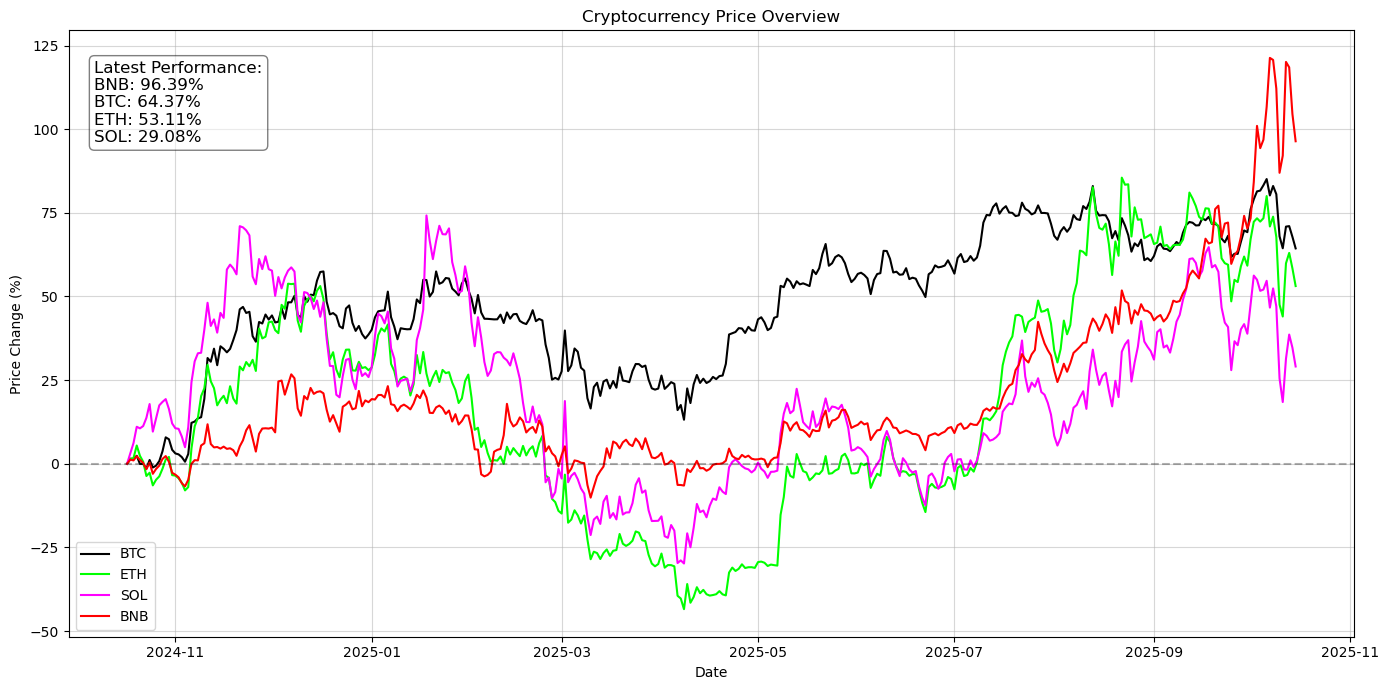

In [186]:
def crypto_data_overview(crypto_data):
    for symbol, data in crypto_data.items():
        print(f"--- {symbol} ---")
        print(f"Data Shape : {data.shape}")
        print(f"Date Range : {data.index.min().date()} to {data.index.max().date()}")

        # Check basic data quality
        missing_values = data.isnull().sum().sum()
        zero_volume = (data["Volume"] == 0).sum()

        if missing_values > 0:
            print(f"Missing Values Detected:\n{missing_values}")
        if zero_volume > 0:
            print(f"Zero Volume Days Detected: {zero_volume}")
        if missing_values == 0 and zero_volume == 0:
            print(f"Data Quality Check Passed: No missing values or zero volume days.")


def plot_price_overview(crypto_data):
    plt.figure(figsize=(14, 7))
    colors = generate_colors(len(crypto_data))

    latest_changes = []
    for i, (symbol, data) in enumerate(crypto_data.items()):
        normalized = (data["Close"] / data["Close"].iloc[0] - 1) * 100
        plt.plot(data.index, normalized, label=symbol, color=colors[i])
        change = normalized.iloc[-1]
        latest_changes.append(f"{symbol}: {change:.2f}%")

    # Sort latest_changes by percentage descending
    latest_changes.sort(key=lambda x: float(x.split(": ")[1][:-1]), reverse=True)

    plt.title("Cryptocurrency Price Overview")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", alpha=0.3)

    plt.text(
        0.02,
        0.95,
        "Latest Performance:\n" + "\n".join(latest_changes),
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()


crypto_data_overview(raw_crypto_data)
plot_price_overview(raw_crypto_data)

In [193]:
def clean_data_trading(data, symbol):
    print(f"\n=== Cleaning Data for {symbol} ===")
    original_length = len(data)
    cleaned = data.copy()

    # # 1️⃣ Cek missing values sebelum dihapus
    missing_before = cleaned.isnull().sum()
    print("\n[Before Cleaning] Missing Values per Column:")
    print(missing_before[missing_before > 0])

    # # 2️⃣ Hapus baris yang punya missing di kolom OHLCV
    cleaned = cleaned.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    print(f"\nRows dropped (missing OHLCV): {original_length - len(cleaned)}")

    # # 3️⃣ Cek inkonsistensi High/Low
    inconsistent_high = (cleaned["High"] < cleaned[["Open", "Close"]].max(axis=1)).sum()
    inconsistent_low = (cleaned["Low"] > cleaned[["Open", "Close"]].min(axis=1)).sum()
    print(f"Inconsistent High values: {inconsistent_high}")
    print(f"Inconsistent Low values: {inconsistent_low}")

    # # 4️⃣ Pastikan High >= Max(Open, Close) dan Low <= min(Open, Close)

    cleaned['High'] = np.maximum(cleaned['High'], np.maximum(cleaned['Open'], cleaned['Close']))
    cleaned['Low'] = np.minimum(cleaned['Low'], np.minimum(cleaned['Open'], cleaned['Close']))

    # # 5️⃣ Handle zero volume
    if 'Volume' in cleaned.columns:
        zero_vol_mask = cleaned['Volume'] <= 0
        if zero_vol_mask.sum() > 0:
            print(f"Need Fix {zero_vol_mask.sum()} volume")
            # Optionally: drop zero volume rows
            # cleaned = cleaned[~zero_vol_mask]

    # 6️⃣ Adjust Extreme Outlier
    for col in ['Open', 'High', 'Low', 'Close']:
        # Calculate Q1, Q3, and IQR
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for extreme outliers (using 3 * IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Identify extreme outliers
        outliers = (cleaned[col] < lower_bound) | (cleaned[col] > upper_bound)
        if outliers.sum() > 0:
            print(f"Adjust {outliers.sum()} extreme outliers in {col}")
            # Instead of removing, cap the values at bounds
            cleaned[col] = cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            print('No Outlier Found')
    
    # 7️⃣ Sort by date (ensure chronological order)
    cleaned = cleaned.sort_index()
    print(f"Data sorted chronologically from {cleaned.index[0].date()} to {cleaned.index[-1].date()}")
    print(f"\nFinal shape: {cleaned.shape} (removed {original_length - len(cleaned)} rows)\n")

    return cleaned


clean_crypto_data = {}
for symbol, data in raw_crypto_data.items():
    clean_crypto_data[symbol] = clean_data_trading(data, symbol)


=== Cleaning Data for BTC ===

[Before Cleaning] Missing Values per Column:
Series([], dtype: int64)

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-17 to 2025-10-15

Final shape: (364, 7) (removed 0 rows)


=== Cleaning Data for ETH ===

[Before Cleaning] Missing Values per Column:
Series([], dtype: int64)

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-17 to 2025-10-15

Final shape: (364, 7) (removed 0 rows)


=== Cleaning Data for SOL ===

[Before Cleaning] Missing Values per Column:
Series([], dtype: int64)

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically 

In [ ]:
def quick_quality_check(crypto_data) :
    all_good = True

    for symbol, data in crypto_data.items():
        print(f"\n{symbol}:\n")
        issues = []

        # Check for missing values
        missing_values = data.isnull().sum()
        if missing_values.any():
            issues.append(f"Missing values detected:\n{missing_values[missing_values > 0]}")

        # Check for Zero price
        zero_prices = (data[['Open', 'High', 'Low', 'Close']] <= 0).sum()
        if zero_prices.any():
            issues.append(f"Zero or negative prices detected:\n{zero_prices[zero_prices > 0]}")

        # Check for data length
        min_required_rows = 100  # Minimum required days of data
        if len(data) < min_required_rows:
            issues.append(f"Insufficient data: {len(data)} rows (minimum {min_required_rows} required)")

        # Check date continuity
        all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
        missing_dates = all_dates.difference(data.index)
        if len(missing_dates) > 0:
            issues.append(f"Missing dates detected: {missing_dates}")

        if issues:
            all_good = False
            print("Issues found:")
            for issue in issues:
                print(f"- {issue}")
        else:
            print("All checks passed!")

    return all_good

data_quality_ok = quick_quality_check(clean_crypto_data)


BTC:

All checks passed!

ETH:

All checks passed!

SOL:

All checks passed!

BNB:

All checks passed!
True


In [ ]:
def volatility_analyze_for_grid(crypto_data) :
    volatility_data = {}

    for symbol, data in crypto_data.items() :
        # Calculate daily returns
        returns = data['Close'].pct_change().dropna()

        # Different volatility measures
        daily_volatility = returns.std() * 100
        weekly_volatility = returns.std() *  np.sqrt(7) * 100
        monthly_volatility = returns.std() *  np.sqrt(30) * 100
        annual_volatility = returns.std() *  np.sqrt(365) * 100

        # Price range analysis
        avg_daily_range = ((data['High'] - data['Low']) / data['Close'] * 100).mean()

        volatility_data[symbol] = {
            'daily_volatility' : daily_volatility,
            'weekly_volatility' : weekly_volatility,
            'monthly_volatility' : monthly_volatility,
            'annual_volatility' : annual_volatility
        }
    

volatility_analysis = volatility_analyze_for_grid(clean_crypto_data)

In [189]:
def plot_performance(df, cryptos, title="Crypto Performance Comparison"):
    df_normalized = (df / df.iloc[0] - 1) * 100  # Normalisasi ke percentage
    colors = generate_colors(len(cryptos))
    
    plt.figure(figsize=(16, 8))

    for i, symbol in enumerate(cryptos):
        plt.plot(df_normalized.index, df_normalized[symbol], label=symbol, color=colors[i], linewidth=2)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (%)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linestyle='--', alpha=0.8)

    # Add latest performance indicator on the plot
    latest_change = df_normalized.iloc[-1].round(1)
    textstr = 'Latest Performance:\n' + '\n'.join([f"{k}: {v:.2f}%" for k, v in latest_change.items()])
    plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# plot_performance(crypto_data_history, crypto_symbols)

In [190]:
def plot_daily_return(df, cryptos=crypto_symbols): 
    colors = generate_colors(len(cryptos))
    # Calculate daily returns
    returns = df.pct_change().dropna()

    # Calculate volatility
    volatility = returns.std() * np.sqrt(365) * 100

    plt.figure(figsize=(12, 6))

    # Subplot 1: Daily Returns Distribution
    plt.subplot(1, 2, 1)
    for i, symbol in enumerate(cryptos):
        plt.hist(returns[symbol] * 100, bins=30, alpha=0.6, label=symbol, color=colors[i])
    
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Volatility Rankings
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(cryptos)), volatility, color=colors, alpha=0.7)
    plt.title('Annualized Volatility Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Cryptocurrency', fontsize=12)
    plt.ylabel('Volatility (%)', fontsize=12)
    plt.xticks(range(len(cryptos)), [c.replace('-USD', '') for c in df.columns])
    plt.grid(True, alpha=0.3)

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{volatility.iloc[i]:.0f}%', 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# plot_daily_return(crypto_data_history)


In [191]:
# Data Acquisition
